In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import sampler
from torch.utils.data import DataLoader

import torchvision.datasets as dset
import torchvision.transforms as T

import timeit

import models
import solver
import views

In [3]:
dtype = torch.FloatTensor
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor

print_every = 100

def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()
    
    
def show_solver_training(solver):
    views.show_traning(solver.loss_history, solver.train_acc_history, solver.val_acc_history)

    
def show_mean_and_std_hist(parameters):
    paras = [w.data.cpu().numpy() for w in parameters]
    views.plot_mean_std_hist(paras)

    
def show_conv_layer_weights(conv_weights):
    conv_weights = conv_weights.data.cpu().numpy()
    conv_weights = conv_weights.transpose(0, 2, 3, 1)
    views.show_conv_weights(conv_weights)

    
def compare_solvers_tranings(solvers_with_labels):
    loss_train_val_acc_with_labels = {}
    for label, solver in solvers_with_labels.items():
        loss_train_val_acc_with_labels[label] = (solver.loss_history, solver.train_acc_history, solver.val_acc_history)
    
    views.compare_trainings(loss_train_val_acc_with_labels)

def compare_training_stats(train_stats):
    loss_train_val_acc_with_labels = { }
    
    for (lr, reg) in train_stats:
        train_acc, val_acc, loss_history = train_stats[(lr, reg)]
        loss_train_val_acc_with_labels[str(lr) + ' ' + str(reg)] = (loss_history, train_acc, val_acc)
    
    views.compare_trainings(loss_train_val_acc_with_labels)

In [4]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset.
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from"""
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start
        
    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))
    
    def __len__(self):
        return self.num_samples
    
NUM_TRAIN = 49000
NUM_VAL = 1000

NUM_TRAIN_SMALL = 64

cifar10_train_small = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
loader_train_small = DataLoader(cifar10_train_small, batch_size=64, sampler=ChunkSampler(NUM_TRAIN_SMALL, 0))

cifar10_train = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
loader_train = DataLoader(cifar10_train, batch_size=64, sampler=ChunkSampler(NUM_TRAIN, 0))

cifar10_val = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
# cifar10_val = cifar10_train # can do this?
loader_val = DataLoader(cifar10_val, batch_size=64, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

cifar10_test = dset.CIFAR10('../cs231n/datasets/', train=False, download=True, transform=T.ToTensor())
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# 1. cross validate small-filter-bn-dropout-net

In [ ]:
torch.cuda.random.manual_seed(12345)

train_stats = { }

#sf_model = models.SmallFilterDropoutNet().type(dtype)
sf_loss_fn = nn.CrossEntropyLoss().type(dtype)

max_count = 1

for i in range(max_count):
    lr = 10**np.random.uniform(-5, -1)
    reg = 10**np.random.uniform(-6, -1)
    #lr = 1e-3*np.random.uniform(6.0, 9.5)
    #reg = 1e-2*np.random.uniform(0.5, 3.5)
    lr = 8.2e-3 * 0.2
    reg = 8.3e-3
    
    num_epochs = 51

    step_size = 5
    gamma = 0.5
    verbose = True
    
    #sf_model.apply(reset)

    sf_optimizer = optim.SGD(sf_model.parameters(), lr=lr, momentum=0.9, weight_decay=reg)
    sf_lr_scheduler = lr_scheduler.StepLR(sf_optimizer, step_size=step_size, gamma=gamma)
    sf_lr_scheduler = None
    
    sf_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                          model=sf_model,
                                          loss_fn=sf_loss_fn,
                                          optimizer=sf_optimizer,
                                          scheduler=sf_lr_scheduler,
                                          dtype=dtype,
                                          num_epochs=num_epochs,
                                          verbose=verbose
                                         )

    sf_solver.train()
    small_filter_solver = sf_solver
    
    train_stats[(lr, reg)] = (small_filter_solver.train_acc_history, small_filter_solver.val_acc_history, small_filter_solver.loss_history)
    print('val accuracy: %f, train accuracy: %f, final loss: %f, lr: %e, reg: %e' % (
        small_filter_solver.val_acc_history[-1], small_filter_solver.train_acc_history[-1], small_filter_solver.loss_history[-1], lr, reg))

t = 0, loss = 0.5238
t = 100, loss = 0.2505
t = 200, loss = 0.4146
t = 300, loss = 0.4889
t = 400, loss = 0.3741
t = 500, loss = 0.4877
t = 600, loss = 0.4075
t = 700, loss = 0.3609
(Epoch 0 / 51) train acc: 0.921875; val acc: 0.761000
t = 0, loss = 0.2887
t = 100, loss = 0.3034
t = 200, loss = 0.3141
t = 300, loss = 0.4229
t = 400, loss = 0.3238
t = 500, loss = 0.4335
t = 600, loss = 0.2718
t = 700, loss = 0.3366
(Epoch 1 / 51) train acc: 0.935547; val acc: 0.769000
t = 0, loss = 0.2669
t = 100, loss = 0.2406
t = 200, loss = 0.2686
t = 300, loss = 0.3938
t = 400, loss = 0.2576
t = 500, loss = 0.4144
t = 600, loss = 0.2817
t = 700, loss = 0.3420
(Epoch 2 / 51) train acc: 0.913086; val acc: 0.765000
t = 0, loss = 0.2614
t = 100, loss = 0.2483
t = 200, loss = 0.2812
t = 300, loss = 0.3083
t = 400, loss = 0.2554
t = 500, loss = 0.2795
t = 600, loss = 0.2230
t = 700, loss = 0.2427
(Epoch 3 / 51) train acc: 0.932617; val acc: 0.772000
t = 0, loss = 0.2029
t = 100, loss = 0.1802
t = 200, los

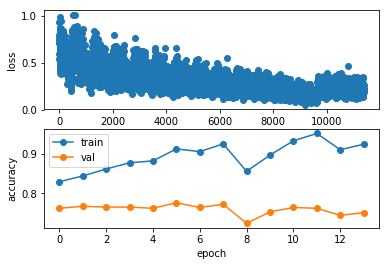

In [21]:
show_solver_training(sf_solver)